In [71]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import requests
import csv
import requests
from bs4 import BeautifulSoup
import re
import time
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Search Keywords

In [ ]:



def read_keywords_from_csv(file_path):
    keywords = []
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            primary = row['Primary Keyword']
            secondary = row['Secondary Keyword']
            keyword_phrase = row['Keyword Phrase']  # f"{primary} {secondary}"
            keywords.append({
                'Keyword_Phrase': keyword_phrase,
                'Primary Keyword': primary,
                'Secondary Keyword': secondary
            })
    return keywords

def fetch_search_results(keyword, num_results=100):
    results = []
    for start in range(1, num_results, 10):  # Pagination for up to 100 results (10 per request)
        response = requests.get(
            f"https://www.googleapis.com/customsearch/v1?q={keyword['Keyword_Phrase']}&key={API_KEY}&cx={CX_ID}&start={start}"
        )
        data = response.json()
        for i, item in enumerate(data.get('items', []), start=start):
            results.append({
                'Keyword_Phrase': keyword['Keyword_Phrase'],
                'Primary Keyword': keyword['Primary Keyword'],
                'Secondary Keyword': keyword['Secondary Keyword'],
                'Rank': i,
                'Title': item['title'],
                'Link': item['link']
            })
    return results

# Read keywords from CSV
keywords = read_keywords_from_csv('keywords.csv')

# Collect results for all keywords
all_results = []
for keyword in keywords:
    all_results.extend(fetch_search_results(keyword))

# Write results to CSV
with open('search_results.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Keyword_Phrase', 'Primary Keyword', 'Secondary Keyword', 'Rank', 'Title', 'Link']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for result in all_results:
        writer.writerow(result)

print("Search results saved to search_results.csv")


Search results saved to search_results.csv


## Building Raw Matrix Dataset

In [9]:

def fetch_page_content(url):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, timeout=10, headers=headers)
        return response.text
    except Exception as e:
        print(f"Error fetching {url}: {str(e)}")
        return ""

def get_raw_metrics(url, content, primary_keyword, secondary_keyword):
    metrics = {'URL': url}
    
    try:
        soup = BeautifulSoup(content, 'html.parser')
        text_content = soup.get_text().lower()
        words = re.findall(r'\w+', text_content)
        
        # Keyword metrics
        primary_keyword_count = words.count(primary_keyword.lower())
        secondary_keyword_count = words.count(secondary_keyword.lower())
        title = soup.title.string if soup.title else ""
        
        # Image metrics
        images = soup.find_all('img')
        images_with_alt = [img['alt'] for img in images if img.has_attr('alt')]
        images_missing_alt = len(images) - len(images_with_alt)
        alt_text_with_keyword = sum(primary_keyword.lower() in alt.lower() or secondary_keyword.lower() in alt.lower() for alt in images_with_alt)
        avg_alt_text_length = sum(len(alt) for alt in images_with_alt) / len(images_with_alt) if images_with_alt else 0
        
        # Meta description metrics
        meta_descriptions = soup.find_all('meta', attrs={'name': 'description'})
        meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
        meta_description_texts = [meta['content'] for meta in meta_descriptions if 'content' in meta.attrs]
        keyword_in_meta_description = any(primary_keyword.lower() in desc.lower() or secondary_keyword.lower() in desc.lower() for desc in meta_description_texts)
        
        # Calculate metrics
        metrics.update({
            'Total Word Count': len(words),
            'Primary Keyword Occurrences': primary_keyword_count,
            'Primary Keyword in Title': primary_keyword.lower() in title.lower() if title else False,
            'Primary Keyword in URL': primary_keyword.lower() in url.lower(),
            'Secondary Keyword Occurrences': secondary_keyword_count,
            'Secondary Keyword in Title': secondary_keyword.lower() in title.lower() if title else False,
            'Secondary Keyword in URL': secondary_keyword.lower() in url.lower(),
            
            'Title Length': len(title) if title else 0,
            'Number of H1 Tags': len(soup.find_all('h1')),
            'Number of H2 Tags': len(soup.find_all('h2')),
            'Number of H3 Tags': len(soup.find_all('h3')),
            'Total Headings': len(soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])),
            
            'Number of Images': len(images),
            'Total Images': len(images),
            'Images with Alt Text': len(images_with_alt),
            'Images Missing Alt Text': images_missing_alt,
            'Alt Text Percentage': (len(images_with_alt) / len(images) * 100) if images else 0,
            'Keyword in Alt Text': alt_text_with_keyword,
            'Average Alt Text Length': avg_alt_text_length,
            
            'Number of Paragraphs': len(soup.find_all('p')),
            'Number of Links': len(soup.find_all('a')),
            'Page Load Time (seconds)': check_page_load_speed(url),
            'Has Mobile Viewport': bool(soup.find('meta', attrs={'name': 'viewport'})),
            'Uses HTTPS': url.startswith('https://'),
            
            'Has Meta Description': bool(meta_descriptions),
            'Number of Meta Descriptions': len(meta_descriptions),
            'Keyword in Meta Description': keyword_in_meta_description,
            'Meta Description Length': len(meta_description_texts[0]) if meta_description_texts else 0,
            'Has Meta Keywords': bool(meta_keywords),
            'Meta Keywords Length': len(meta_keywords['content']) if meta_keywords and meta_keywords.get('content') else 0,
            
            'Average Words Per Paragraph': len(words) / len(soup.find_all('p')) if soup.find_all('p') else 0,
            'Text-to-HTML Ratio': len(text_content) / len(content) if content else 0,
            'Response Size (bytes)': len(content)
        })
        
    except Exception as e:
        print(f"Error processing metrics for {url}: {str(e)}")
        metrics.update({key: 0 for key in [
            'Total Word Count', 'Primary Keyword Occurrences', 'Primary Keyword in Title', 'Primary Keyword in URL',
            'Secondary Keyword Occurrences', 'Secondary Keyword in Title', 'Secondary Keyword in URL',
            'Title Length', 'Number of H1 Tags', 'Number of H2 Tags', 'Number of H3 Tags', 'Total Headings',
            'Number of Images', 'Total Images', 'Images with Alt Text', 'Images Missing Alt Text', 
            'Alt Text Percentage', 'Keyword in Alt Text', 'Average Alt Text Length', 'Number of Paragraphs', 
            'Number of Links', 'Page Load Time (seconds)', 'Has Mobile Viewport', 'Uses HTTPS', 'Has Meta Description',
            'Number of Meta Descriptions', 'Keyword in Meta Description', 'Meta Description Length', 
            'Has Meta Keywords', 'Meta Keywords Length', 'Average Words Per Paragraph', 'Text-to-HTML Ratio',
            'Response Size (bytes)'
        ]})
    
    return metrics

def check_page_load_speed(url):
    try:
        start_time = time.time()
        requests.get(url, timeout=10)
        return time.time() - start_time
    except:
        return 0

def classify_rank(rank):
    if 1 <= rank <= 20:
        return "Top"
    elif 21 <= rank <= 60:
        return "Average"
    elif 61 <= rank <= 100:
        return "Below Average"
    else:
        return "Unranked"

def analyze_pages_from_csv(csv_file_path):
    all_metrics = []
    df = pd.read_csv(csv_file_path)
    
    for _, row in df.iterrows():
        primary_keyword = row['Primary Keyword']
        secondary_keyword = row['Secondary Keyword']
        url = row['Link']
        rank = row['Rank']
        classification = classify_rank(rank)
        
        print(f"Processing {url}")
        content = fetch_page_content(url)
        if content:
            metrics = get_raw_metrics(url, content, primary_keyword, secondary_keyword)
            metrics['Rank Classification'] = classification
            metrics['Primary Keyword'] = primary_keyword
            metrics['Secondary Keyword'] = secondary_keyword
            metrics['Rank'] = rank
            all_metrics.append(metrics)
            print(f"Processed {url}")
    
    result_df = pd.DataFrame(all_metrics)
    result_df.to_csv('page_raw_metrics_all_article.csv', index=False)
    return result_df

# Example usage
df = analyze_pages_from_csv("search_results.csv")
print("\nRaw metrics with classification have been saved to 'page_raw_metrics_all_article.csv'")

Processing https://www2.deloitte.com/us/en/pages/operations/articles/blockchain-supply-chain-innovation.html
Processed https://www2.deloitte.com/us/en/pages/operations/articles/blockchain-supply-chain-innovation.html
Processing https://www.ibm.com/blockchain-supply-chain
Processed https://www.ibm.com/blockchain-supply-chain
Processing https://hbr.org/2020/05/building-a-transparent-supply-chain
Processed https://hbr.org/2020/05/building-a-transparent-supply-chain
Processing https://www.paltron.com/insights-en/the-role-of-blockchain-in-supply-chain-management-scm
Processed https://www.paltron.com/insights-en/the-role-of-blockchain-in-supply-chain-management-scm
Processing https://supplychaindigital.com/top10/top-10-uses-of-blockchain-in-supply-chain
Processed https://supplychaindigital.com/top10/top-10-uses-of-blockchain-in-supply-chain
Processing https://www.weforum.org/stories/2024/08/blockchain-food-supply-chain/
Processed https://www.weforum.org/stories/2024/08/blockchain-food-supply

In [79]:
df = pd.read_csv('page_raw_metrics_all_article_220.csv')
# Drop records where Total Word Count is less than 120
df = df[df['Total Word Count'] >= 120]

## EDA of the Dataset 

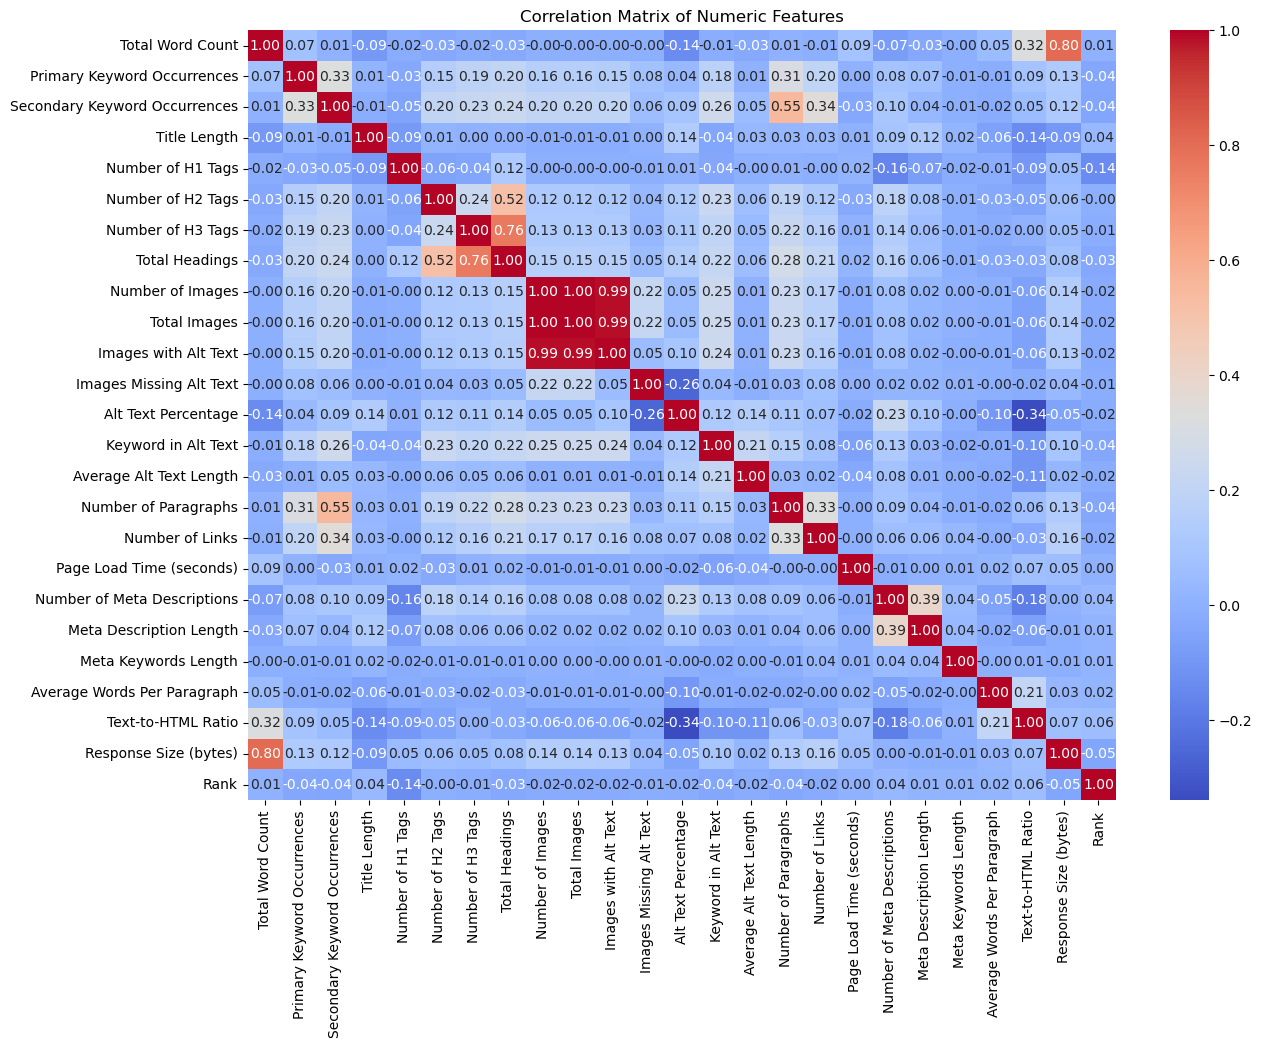

/var/folders/c3/fp20mf856mn7bnz2vyhl2jp40000gp/T/ipykernel_38657/1601591121.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df['Rank Classification'], palette="viridis")


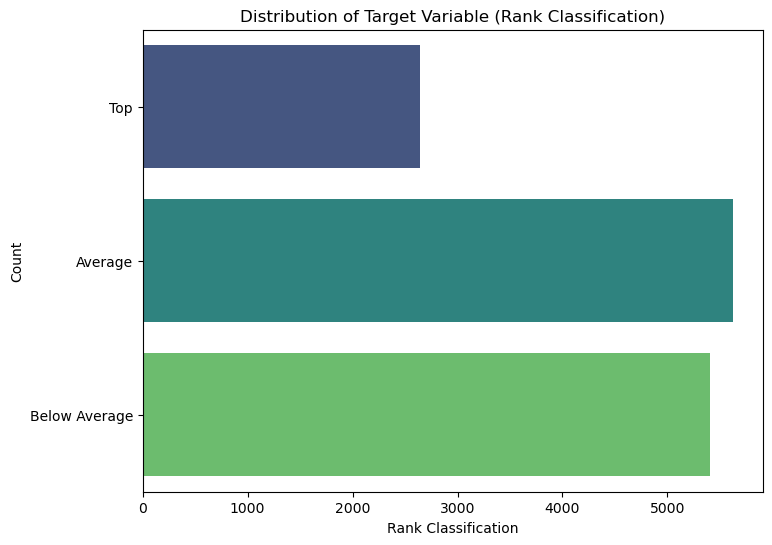

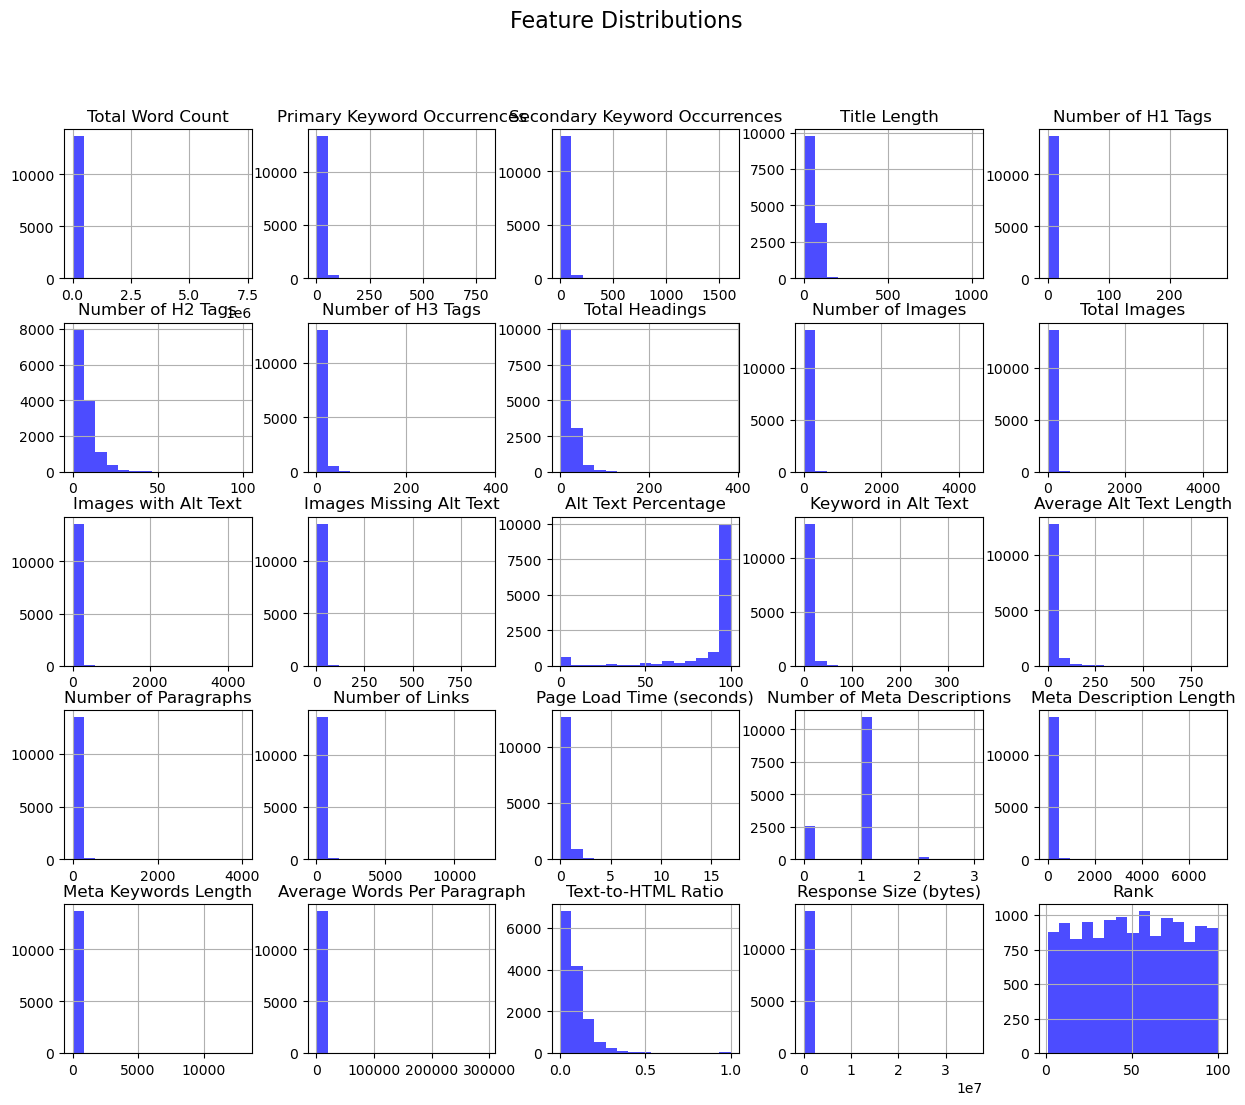

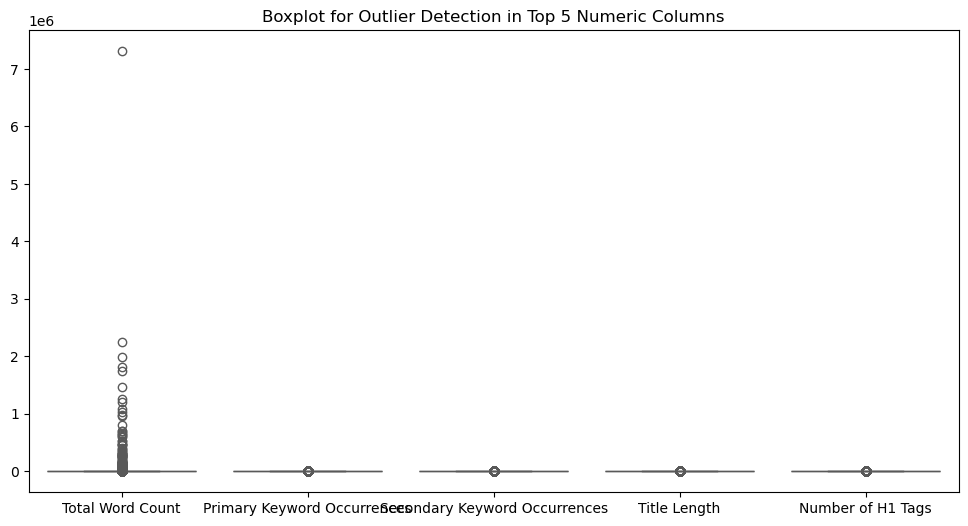

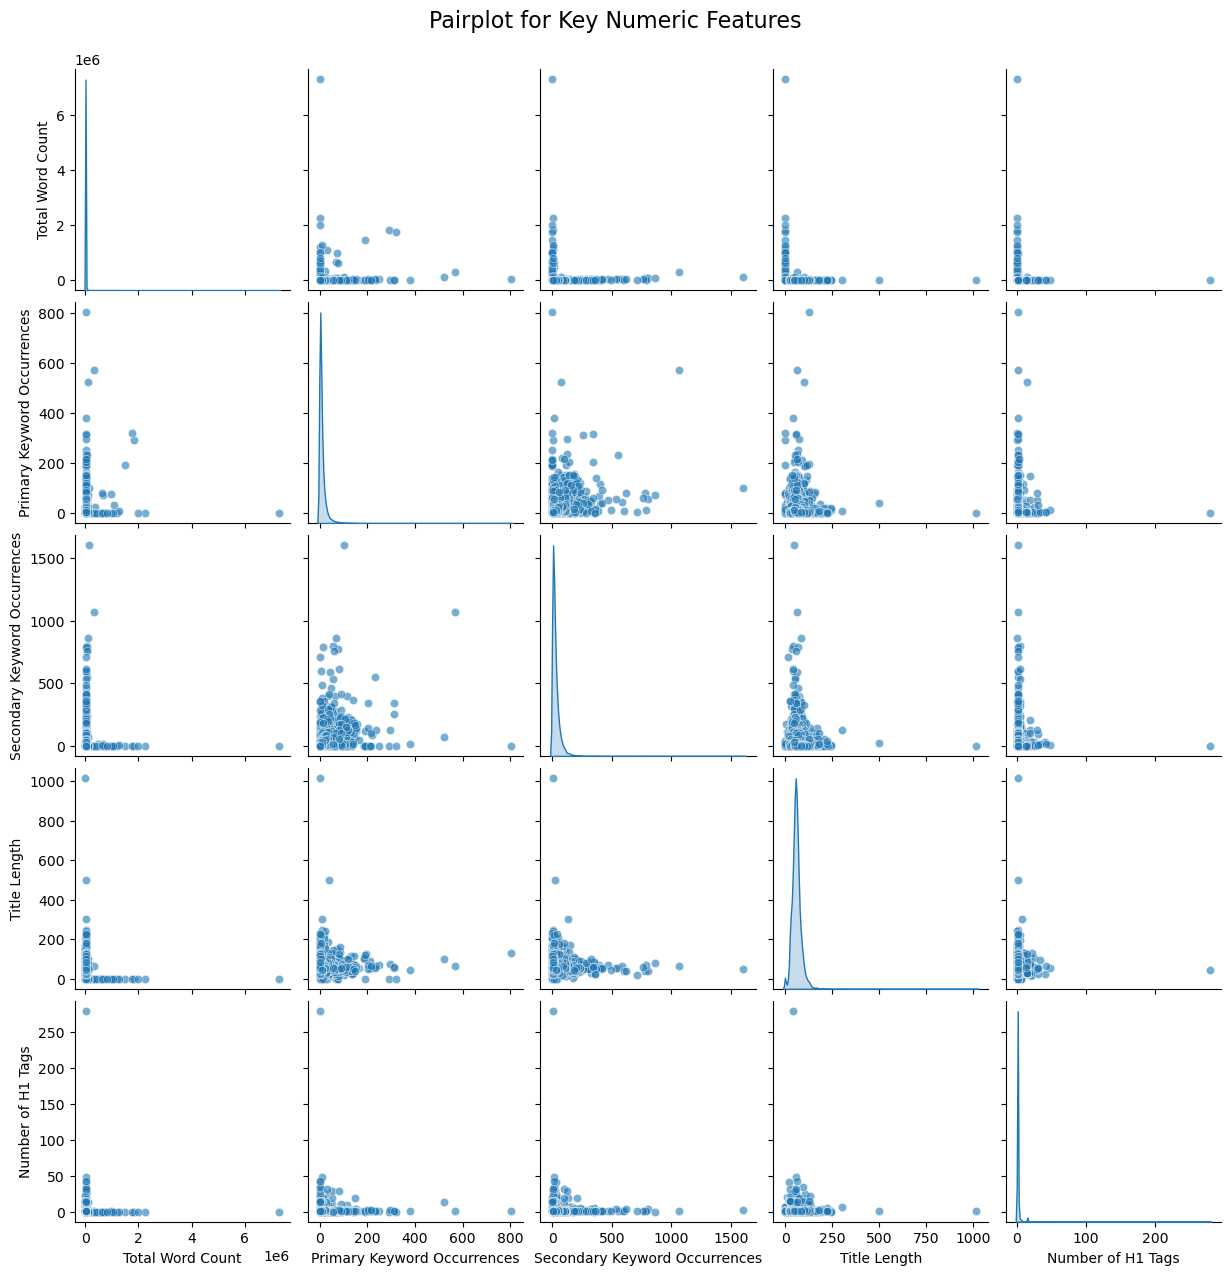

In [78]:

# Step 1: Identify Numeric Columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Handle Missing and Invalid Values
# Replace invalid values with NaN and drop rows with NaN
cleaned_data = df[numeric_columns].apply(pd.to_numeric, errors='coerce').dropna()

# Step 3: Correlation Matrix
plt.figure(figsize=(14, 10))
correlation_matrix = cleaned_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Step 4: Distribution of Target Variable
if 'Rank Classification' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(df['Rank Classification'], palette="viridis")
    plt.title("Distribution of Target Variable (Rank Classification)")
    plt.xlabel("Rank Classification")
    plt.ylabel("Count")
    plt.show()

# Step 5: Feature Distributions
cleaned_data.hist(figsize=(15, 12), bins=15, color='blue', alpha=0.7)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Step 6: Boxplot for Outlier Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=cleaned_data.iloc[:, :5], palette="Set2")  # Boxplot for first 5 numeric columns
plt.title("Boxplot for Outlier Detection in Top 5 Numeric Columns")
plt.show()

# Step 7: Pairplot of Key Numeric Features
key_features = cleaned_data.columns[:5]  # Selecting the top 5 numeric features
sns.pairplot(cleaned_data[key_features], diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot for Key Numeric Features", y=1.02, fontsize=16)
plt.show()


## Building Machine learning model 

In [80]:
df.isna().sum()

URL                              0
Total Word Count                 0
Primary Keyword Occurrences      0
Primary Keyword in Title         0
Primary Keyword in URL           0
Secondary Keyword Occurrences    0
Secondary Keyword in Title       0
Secondary Keyword in URL         0
Title Length                     0
Number of H1 Tags                0
Number of H2 Tags                0
Number of H3 Tags                0
Total Headings                   0
Number of Images                 0
Total Images                     0
Images with Alt Text             0
Images Missing Alt Text          0
Alt Text Percentage              0
Keyword in Alt Text              0
Average Alt Text Length          0
Number of Paragraphs             0
Number of Links                  0
Page Load Time (seconds)         0
Has Mobile Viewport              0
Uses HTTPS                       0
Has Meta Description             0
Number of Meta Descriptions      0
Keyword in Meta Description      0
Meta Description Len

In [81]:
X = df.drop(['Rank Classification',"URL","Total Images","Rank","Primary Keyword", "Secondary Keyword"], axis=1) # 
y = df['Rank Classification']

In [82]:
y

0                  Top
1                  Top
2                  Top
3                  Top
4                  Top
             ...      
16252    Below Average
16253    Below Average
16254    Below Average
16255    Below Average
16256    Below Average
Name: Rank Classification, Length: 13677, dtype: object

In [83]:
label_encoder = LabelEncoder()

# Step 2: Fit and transform the specific column
y = label_encoder.fit_transform(y)

In [84]:
y

array([2, 2, 2, ..., 1, 1, 1])

In [85]:
# Step 1: Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Step 2: Label Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store the encoder for reverse transformations if needed

# Step 3: Scale numerical columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

Explained Variance Ratio for PCA 1: 0.14353
Explained Variance Ratio for PCA 2: 0.23503
Explained Variance Ratio for PCA 3: 0.30592
Explained Variance Ratio for PCA 4: 0.36932
Explained Variance Ratio for PCA 5: 0.42538
Explained Variance Ratio for PCA 6: 0.47844
Explained Variance Ratio for PCA 7: 0.52507
Explained Variance Ratio for PCA 8: 0.56996
Explained Variance Ratio for PCA 9: 0.61137
Explained Variance Ratio for PCA 10: 0.65162
Explained Variance Ratio for PCA 11: 0.6911
Explained Variance Ratio for PCA 12: 0.72856
Explained Variance Ratio for PCA 13: 0.7633
Explained Variance Ratio for PCA 14: 0.79584
Explained Variance Ratio for PCA 15: 0.82732
Explained Variance Ratio for PCA 16: 0.85612
Explained Variance Ratio for PCA 17: 0.88363
Explained Variance Ratio for PCA 18: 0.90731
Explained Variance Ratio for PCA 19: 0.92856
Explained Variance Ratio for PCA 20: 0.94817
Explained Variance Ratio for PCA 21: 0.96245
Explained Variance Ratio for PCA 22: 0.97187
Explained Variance Ra

Text(0, 0.5, 'Explained Variance Ratio')

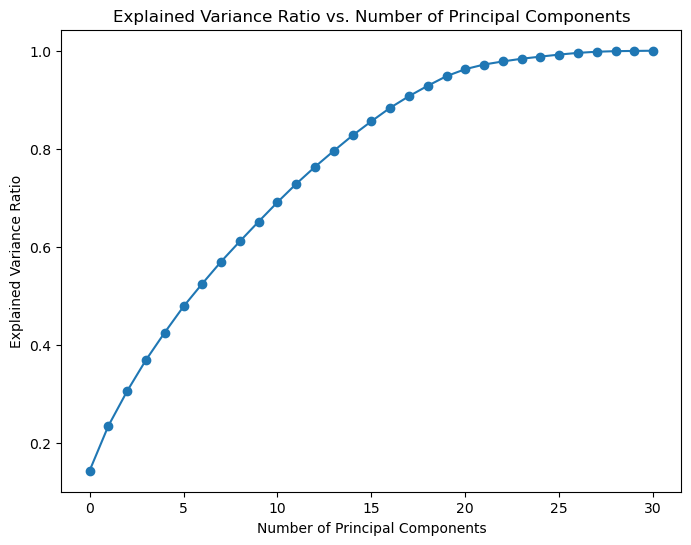

In [86]:
explained_variance_ratio_sum_list = []
# 3. Apply PCA
for i in range(1,X.shape[1]):
  pca = PCA(n_components=i)  # Choose the number of principal components you want
  principal_components = pca.fit_transform(X)

  # 4. Create a DataFrame with the principal components
  # principal_df = pd.DataFrame(data=principal_components)

  # 5. (Optional) Explained variance ratio
  explained_variance_ratio_sum = round(pca.explained_variance_ratio_.sum(),5)
  explained_variance_ratio_sum_list.append(explained_variance_ratio_sum)
  print(f"Explained Variance Ratio for PCA {i}: {explained_variance_ratio_sum}")

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_sum_list, marker='o')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')


In [63]:
pca = PCA(n_components=20)  # Choose the number of principal components you want
X_pca = pca.fit_transform(X)

In [64]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Check the new distribution of classes
print(f"Original class distribution: {pd.Series(y_train).value_counts()}")
print(f"Resampled class distribution: {pd.Series(y_train_resampled).value_counts()}")

# Define models to train
models = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "Logistic Regression": LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier()
}

# Dictionary to store performance of each model
model_performance = {}

# Train each model and evaluate it
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test_resampled)

    # Calculate metrics
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred, average='macro')
    recall = recall_score(y_test_resampled, y_pred, average='macro')

    # Store the performance
    model_performance[model_name] = {
        "Model": model,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

# Find the best model based on accuracy, precision, and recall
best_model_name = max(model_performance, key=lambda k: (
    model_performance[k]['Accuracy'],
    model_performance[k]['Precision'],
    model_performance[k]['Recall']
))
best_model = model_performance[best_model_name]

# Output the best model and its metrics
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_model['Accuracy']}%")
print(f"Precision: {best_model['Precision']}")
print(f"Recall: {best_model['Recall']}")

Original class distribution: 0    4512
1    4300
2    2129
Name: count, dtype: int64
Resampled class distribution: 0    4512
1    4512
2    4512
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Model: Random Forest
Accuracy: 0.41591861160981447%
Precision: 0.4515537352075305
Recall: 0.4159186116098145


In [67]:
# Hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [10, 50, 100],
        "max_depth": [None, 10, 20]
    },
    "Support Vector Classifier": {
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    "Logistic Regression": {
        "multi_class": ["multinomial", "ovr"],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [100, 200, 500]
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 20],
        "criterion": ["gini", "entropy"]
    }
}

# Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Classifier": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Dictionary to store performance of each model
model_performance = {}

# Train each model with GridSearchCV
for model_name, model in models.items():
    print(f"Training {model_name} with GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring="accuracy",
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_resampled)

    # Calculate metrics
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred, average='macro')
    recall = recall_score(y_test_resampled, y_pred, average='macro')

    # Store the performance
    model_performance[model_name] = {
        "Best Params": grid_search.best_params_,
        "Model": best_model,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

# Find the best model based on accuracy, precision, and recall
best_model_name = max(model_performance, key=lambda k: (
    model_performance[k]['Accuracy'],
    model_performance[k]['Precision'],
    model_performance[k]['Recall']
))
best_model = model_performance[best_model_name]

# Output the best model and its metrics
print("\nBest Model Summary:")
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_model['Best Params']}")
print(f"Accuracy: {best_model['Accuracy']:.2f}")
print(f"Precision: {best_model['Precision']:.2f}")
print(f"Recall: {best_model['Recall']:.2f}")

Training Random Forest with GridSearchCV...
Training Support Vector Classifier with GridSearchCV...
Training Logistic Regression with GridSearchCV...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

Training Decision Tree with GridSearchCV...

Best Model Summary:
Best Model: Random Forest
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.42
Precision: 0.46
Recall: 0.42


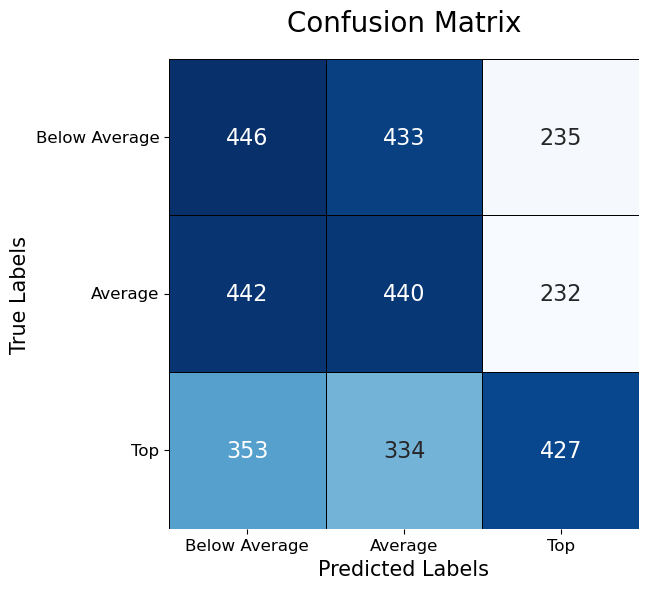

In [72]:
cm = confusion_matrix(y_test_resampled, y_pred)
labels = ['Below Average', 'Average', "Top"]  # Customize class names

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', square=True)

# Customize the plot aesthetics
plt.title('Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, fontsize=12)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, fontsize=12, rotation=0)


# Show the plot
plt.tight_layout()
plt.show()

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Example: Use a classification dataset
from sklearn.datasets import make_classification

# Hyperparameters
input_dim = X_train.shape[1]
num_classes = 1
batch_size = 32
epochs = 20

# Store performance
results = {}

# 1. Dense Neural Network (DNN)
def create_dnn():
    model = Sequential([
        Dense(15, activation='relu', input_shape=(input_dim,)),
        # Dropout(0.1),
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        # Dense(, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

dnn_model = create_dnn()
dnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
results['DNN'] = dnn_model.evaluate(X_test, y_test, verbose=0)[1]  # Accuracy

# 2. Convolutional Neural Network (CNN)
def create_cnn():
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]
cnn_model = create_cnn()
cnn_model.fit(X_train_cnn, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
results['CNN'] = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]

# 3. Long Short-Term Memory (LSTM)
def create_lstm():
    model = Sequential([
        Embedding(input_dim=1000, output_dim=64, input_length=input_dim),
        LSTM(64),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = create_lstm()
lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
results['LSTM'] = lstm_model.evaluate(X_test, y_test, verbose=0)[1]

# 4. Autoencoder
def create_autoencoder():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

autoencoder = create_autoencoder()
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
autoencoder_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
results['Autoencoder'] = 1 - autoencoder_loss  # Flip loss to represent performance

# 5. GAN (Simplified)
# Skipping GAN for simplicity here; they need a custom discriminator-generator architecture.

# Select the best-performing model
best_model = max(results, key=results.get)
print(f"Best Model: {best_model} with Accuracy: {results[best_model]:.2f}")

2024-12-02 02:05:07.918718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4004 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3981 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3983 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3991 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3976 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4006 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4016 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accur

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3995 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3859 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3915 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3930 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3929 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3937 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3979 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accur

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3903 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4045 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3929 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3967 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3872 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3954 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3942 - loss: 0.0000e+00 - val_accuracy: 0.3778 - val_loss: 0.0000e+00
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step